<a href="https://colab.research.google.com/github/B4Farouk/smpl-dr-clip/blob/main/Juliette_Interacting_with_CLIP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CLIP

###Préparations for Colab
Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the clip package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ytchtcb4
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ytchtcb4
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=fe4270325c841db93fef6fded325bbd6bb00705cd0d9e1ba950ccde239404223
  Stored in directory: /tmp/pip-ephem-wheel-cache-34gj7xmh/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch.nn.functional as functional
import torch
from pkg_resources import packaging

import clip

print("Torch version:", torch.__version__)

Torch version: 1.12.1+cu113


### Loading the CLIP model


In [ ]:
print("These are CLIP available models : ", clip.available_models())

These are CLIP available models :  ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [ ]:
model, preprocess = clip.load("ViT-B/32") #choose the model ViT-B/32
model.cuda().eval()
#input_resolution = model.visual.input_resolution
#context_length = model.context_length
#vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", model.visual.input_resolution)
print("Context length:", model.context_length)
print("Vocab size:", model.vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 260MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


### Preparing the images and the texts

In [ ]:
images = []

images.append((Image.open("test1.jpg")))
images.append((Image.open("test2.jpg")))
images.append((Image.open("test3.jpg")))
images.append((Image.open("test4.jpg")))

preprocessed_images = (preprocess(im) for im in images)

image_input = torch.tensor(np.stack(preprocessed_images)).cuda()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
texts = []

texts.append("a pumpkin")
texts.append("a man sitting")
texts.append("a house")
texts.append("an apple")

text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

### Building features
We run the forward pass of the model to get the image and text features

In [ ]:
with torch.no_grad():
  image_features = model.encode_image(image_input).float()
  text_features = model.encode_text(text_tokens).float()

### Find the similarity
We normalize the features and calculate the dot product of each pair

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [ ]:
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
print(similarity)
print(sum(similarity[0]))
print(sum(similarity[1]))
print(sum(similarity[:][0]))

[[0.31328788 0.17858519 0.18186119 0.23247835]
 [0.19575982 0.25986263 0.17092809 0.20179358]
 [0.20090906 0.19639261 0.26005217 0.19538902]
 [0.24429286 0.19241875 0.17022511 0.30131763]]
0.9062126129865646
0.8283441215753555
0.9062126129865646


Text(0.5, 1.0, 'Cosine similarity between text and image features')

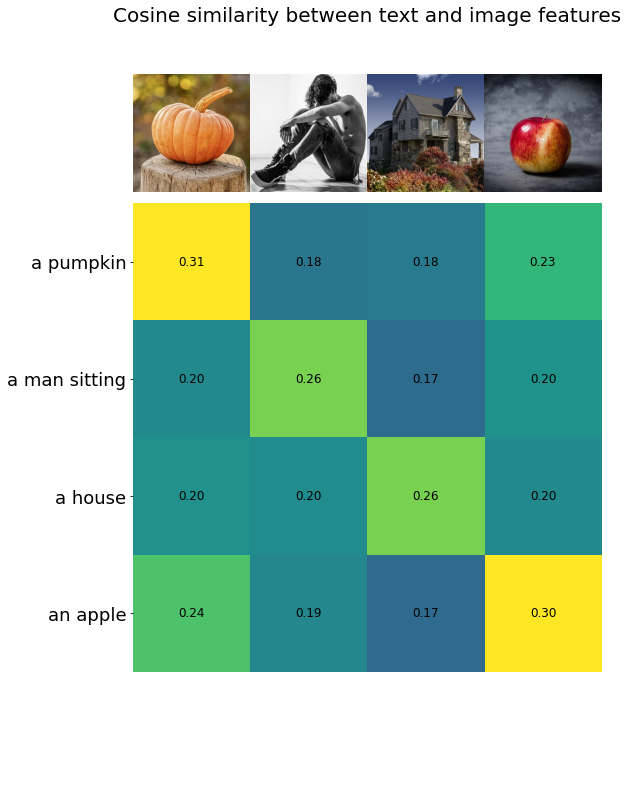

In [ ]:
count = len(texts)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

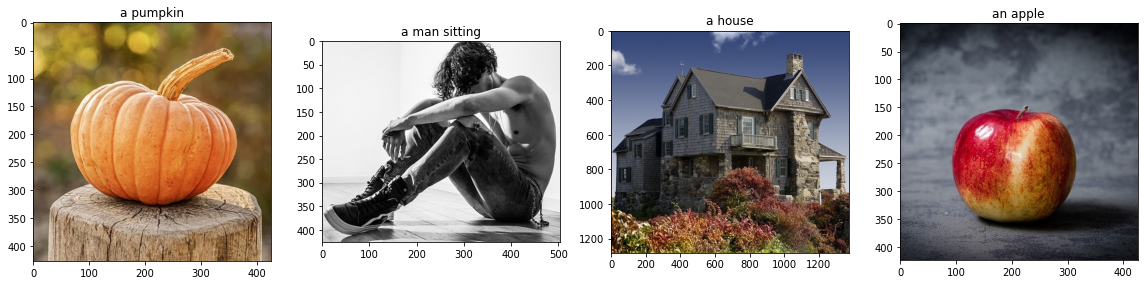

In [ ]:
plt.figure(figsize=(16, 5))
for i in range(len(images)):
  plt.subplot(1, 4, i + 1)
  plt.imshow(np.transpose(images[i],axes=(0, 1,2)))
  plt.title(texts[np.argmax(similarity[i])])
  
plt.tight_layout()

In [ ]:
learning_rate = 1e-4
params = ... # params of the SMPL model
loss_function = functional.mse_loss

loss = similarity

optimizer = torch.optim.SGD(params, lr=learning_rate)

TypeError: ignored